In [1]:
import lightkurve as lk
import numpy as np
import pandas as pd
import glob
from astropy.io import ascii
from astropy.table import Table, join
from astropy.io import fits
import matplotlib.pyplot as plt



# useful functions

In [2]:
#og
def plot_sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        try:
            lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            lcfile = lk.open(lcsectorpath)
            lcfile.scatter()
            plt.title('TIC:{},sector:{}'.format(tic,sec))
        except:
            print('nothing for tic:{} sector:{}'.format(tic,sec))

In [3]:
#remix---only does 1st sector from every tic
def plot_1sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    count = 0
    for sec in sectors:
        lcsectorpaths = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
        if count % 2 == 0:
            try:
                lcfile = lk.open(lcsectorpaths)
                lcfile.scatter()
                plt.title('TIC:{},sector:{}'.format(tic,sec))
                count +=1
            except FileNotFoundError:
                #print('nothing for tic:{} sector:{}'.format(tic,sec))
                count +=2
        else:
            continue

In [4]:
# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

In [5]:
#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a

In [6]:
#tests to make above plots a function

def sector_overlay(sector,log=True,x=None):
    """
    Args:
        sector: sector number (integer)
        log:    True(default); False linear
        x:      plotting range for x axis (tuple)
    """
    secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
    mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
    sectable = secstats[secstats['sector']==sector]
    plt.figure(figsize=(10,5),dpi=200)
    plt.scatter(sectable['Teff'],sectable['ls1'],s=.5,c=sectable['lsamp1'],vmax=1,vmin=.0001, rasterized=True);
    plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.5,vmax=1,vmin=.0001,zorder=0,color = 'grey', rasterized=True)#label='mcquillan is blue');
    plt.xlabel('$\mathrm{T_{eff}}$',fontsize=15);
    plt.ylabel("$\mathrm{Lomb-Scargle~rotation~period}$",fontsize=15);
    plt.colorbar().set_label(label='$\mathrm{Amplitude}$',size=15)
    plt.title('Sector {} ALL L-S RPs'.format(sector,fontsize=20));
    if log == True:
        plt.yscale('log')
    else:
        pass
    if x ==None:
        plt.xlim(6900,3000)
    else:
        plt.xlim(x)

              
    return len(sectable)

In [7]:

# Plots highest amp RP of each sector for ALL SECTORS
def plot_rps(tic,plot=False):
    plt.figure(figsize=(10,5))
    if type(tic)==np.int64: #must be integer
        tic=tic
    else:
        tic=np.int64(tic) #mustve changed allstats table to have IDs that are integers so gotta change fcn to match that
    secs=[]
    rps=[]
    amps=[]
    rvars=[]
    for row in cvzsecs:
# maybe just make given tic & pulled tics datatype match here tic = tic if type(tic) == type(ticid) else tic.dtype == type(ticid)
        ticid = row['ID'] 
        if ticid == tic:
            sec = row['sector']
            rp = row['ls1']
            amp = row['lsamp1']
            rvar = row['rvar']
            secs.append(sec)
            rps.append(rp)
            amps.append(amp)
            rvars.append(rvar)
        else:
            continue
    #summary stats
    print('Average LS1 Rotation Period for TIC {} is:'.format(tic),np.mean(rps))
    mytics = np.repeat(tic,len(secs))
    mytable = Table([mytics,secs,rps,amps,rvars],names=('ID','sector','lsrp1','lsamp1','rvar'))
    print('Highest Amplitude from sector:',int(mytable[mytable['lsamp1']==np.max(mytable['lsamp1'])]['sector']))
    #comparison from stitiched lc
    ########################################
    #maybe put a conditional to verify get right table, for now rely on print statemtn of tic matching
    #ogtt = cvzstats[cvzstats['ID']==str(tic)] #must match dtype for allstats['ID']--fixed above in ifelse
    ogtt = cvzstats[cvzstats['ID'] == tic]
    print('verify:',ogtt['ID'][0],'matches:',tic)
    ########################################
    #plotting
    plt.scatter(mytable['sector'],mytable['lsrp1'],s=15,c=mytable['lsamp1'],vmax=0.05,vmin=0.0,label='RP per sector');   
    #NOTE: below ['NUMsectors'] is the total number of sectors available,values from stitched lcs
    plt.scatter([ogtt['TOTsecs']],[ogtt['ls1']],s=55,marker="^",c=[ogtt['lsamp1']],vmax=0.05,vmin=0.0,label = 'stitched lcs RP')
    print('Stitched RP: ',ogtt['ls1'][0])
    plt.xlabel('sector',fontsize=15)
    plt.ylabel('lsrp1',fontsize=15)
    plt.colorbar().set_label(label='ls amplitude',size=15)
    plt.grid('on')
    plt.legend()
    plt.title('EACH sectors rp for CVZ TIC:{}'.format(tic),fontsize=20)
    if plot == True:
        #to plot lcs of above
        sector = [1,2,3,4,5,6,7,8,9,10,11,12,13]
        tic = tic
        for sec in sector:
            path = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            try:
                lc = lk.open(path)
                lc.scatter()
                plt.title('TIC: {}, SEC: {}'.format(tic,sec))
            except:
                pass
    return mytable

# opening data

In [8]:
secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics
mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
#tics
#cooltics = np.load('data/cool_cvz_tics.npy') #list of old tics
#addtics = np.load('data/additional_cvz_tics.npy') #list of new tics 
alltics = np.load('data/all_dled_tics.npy') # list of new+old tics
goodtics = np.load('data/good_cvz_tics.npy') #only 10+ sectors



#CUTS to data
cvzstats = allstats[allstats['TOTsecs']>=10]
print(len(cvzstats),len(goodtics),'these should be the same, check if not')
cvzsecs = secstats[secstats['NUMsectors']>=10]
print(len(cvzsecs))

6009 6009 these should be the same, check if not
70865


# creating sample

In [19]:
####to check star stats 
tic = 177077475
allstats[allstats['ID']==tic]['Teff']

5478.28


0 : 177036977
1 : 177038077
2 : 177038190
3 : 177038886
4 : 177039559
5 : 177039581
6 : 177075293
7 : 177075958
8 : 177077054
9 : 177077137
10 : 177077336
11 : 177077475
12 : 177077527
13 : 177078853
14 : 177078973
15 : 177079606
16 : 177080894
17 : 177113114
18 : 177113903
19 : 177114260


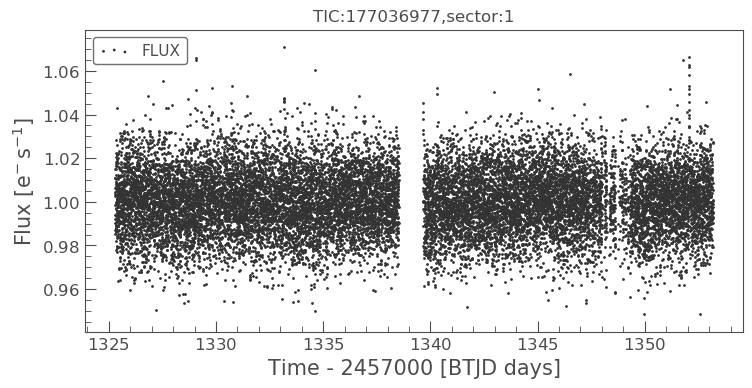

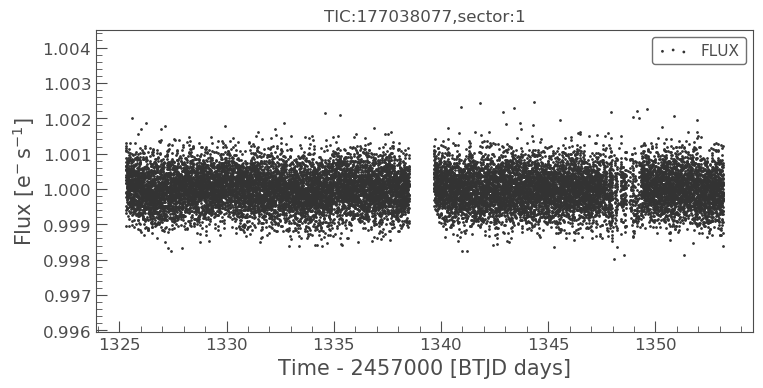

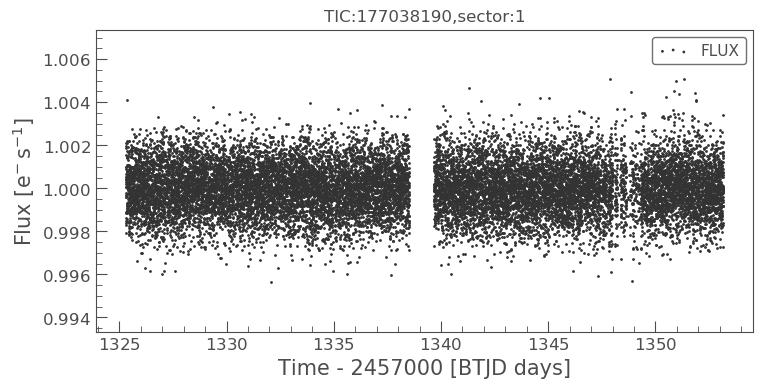

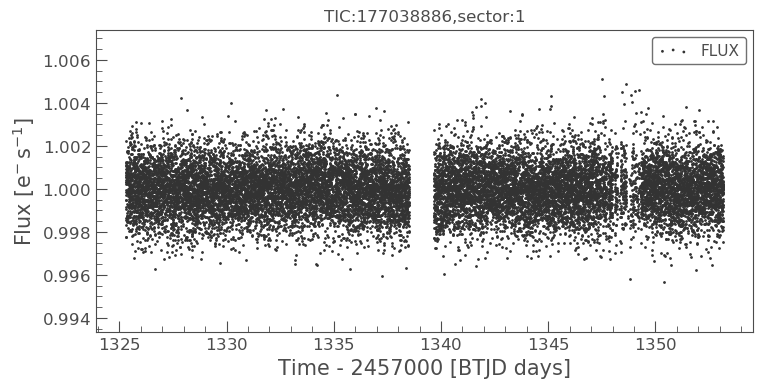

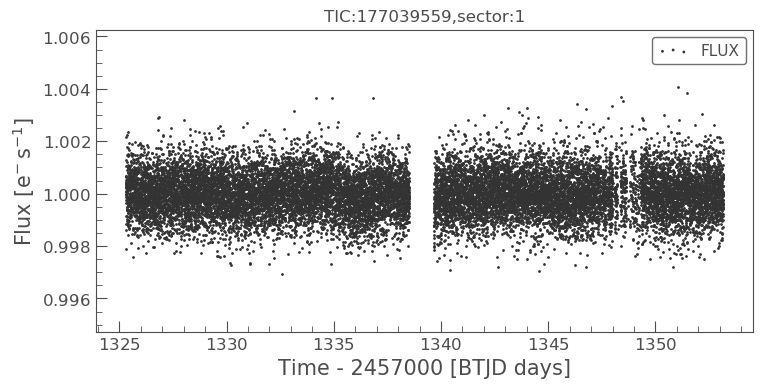

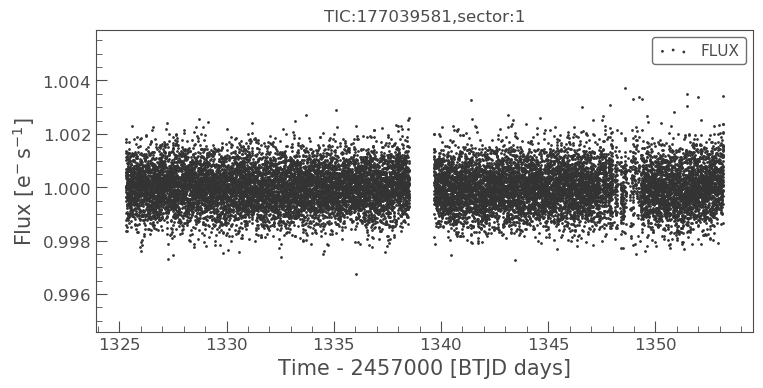

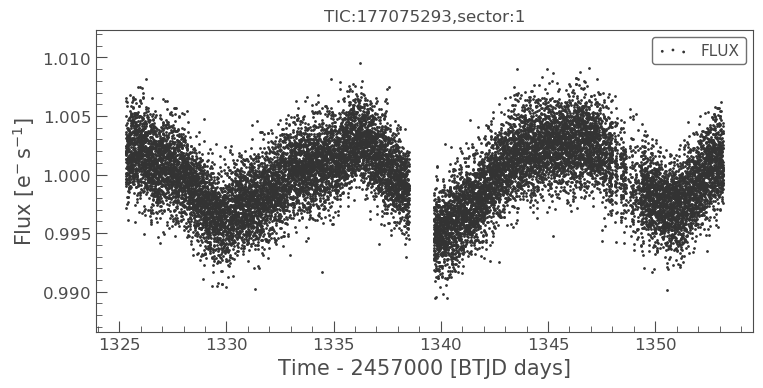

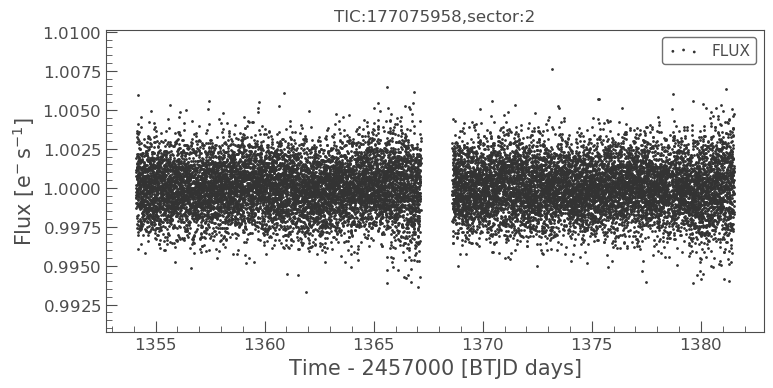

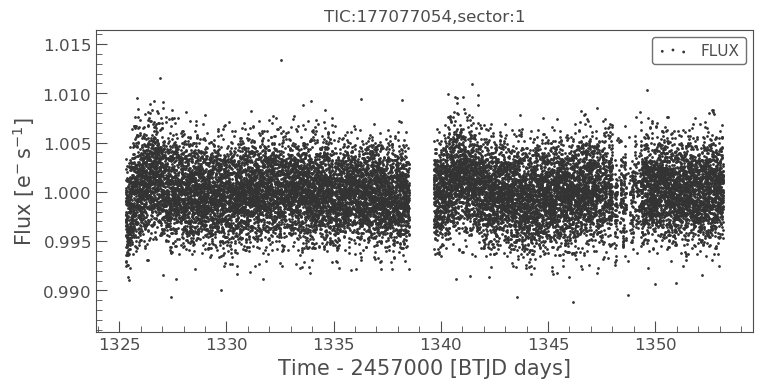

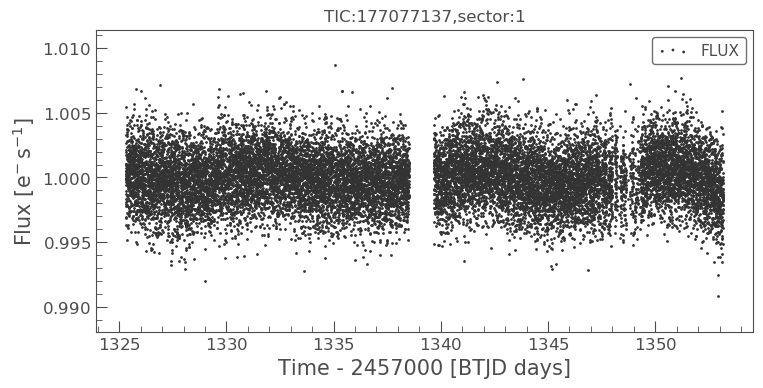

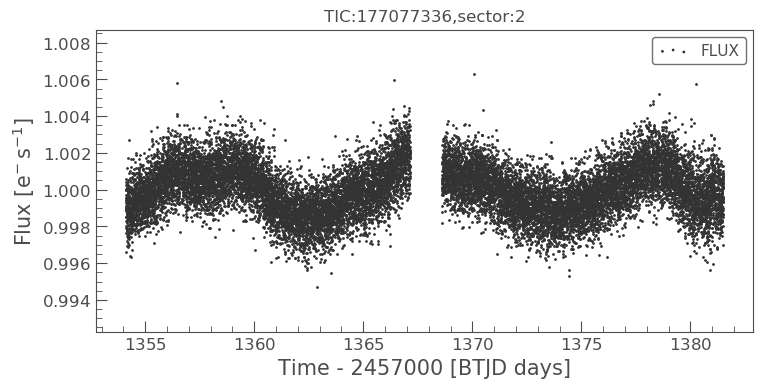

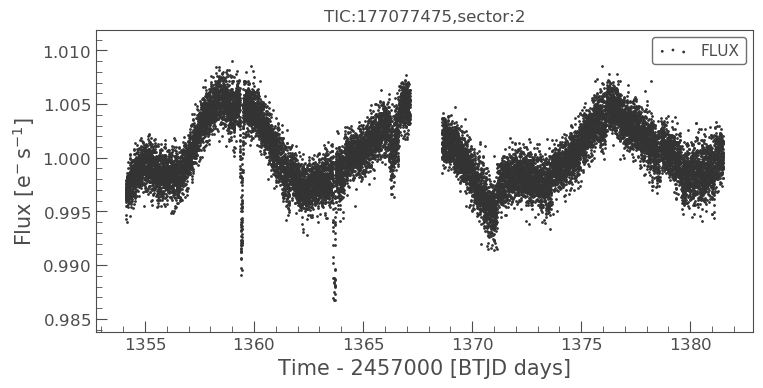

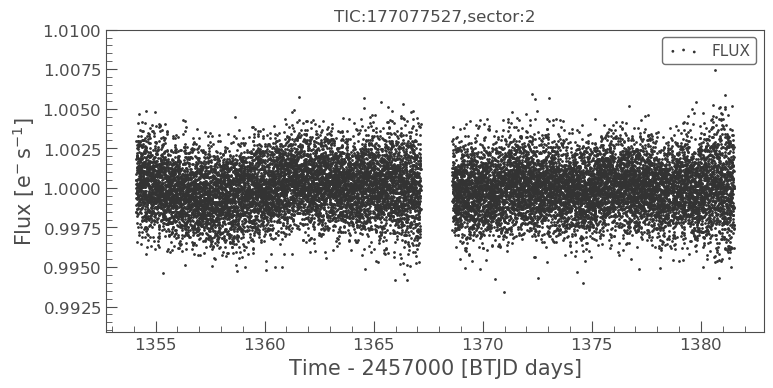

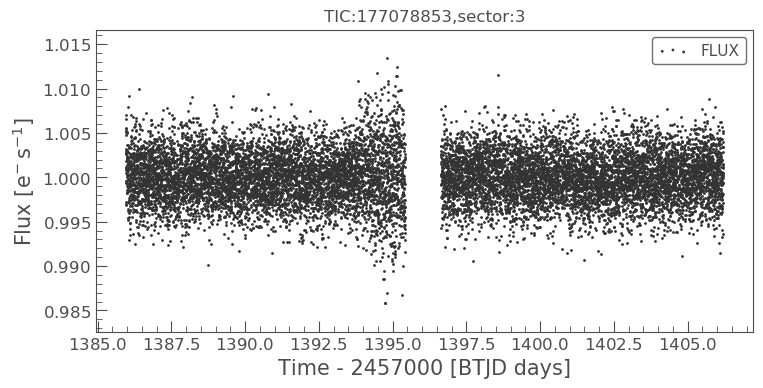

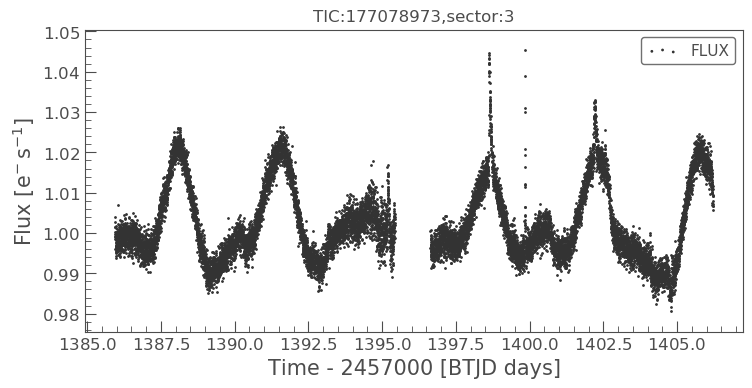

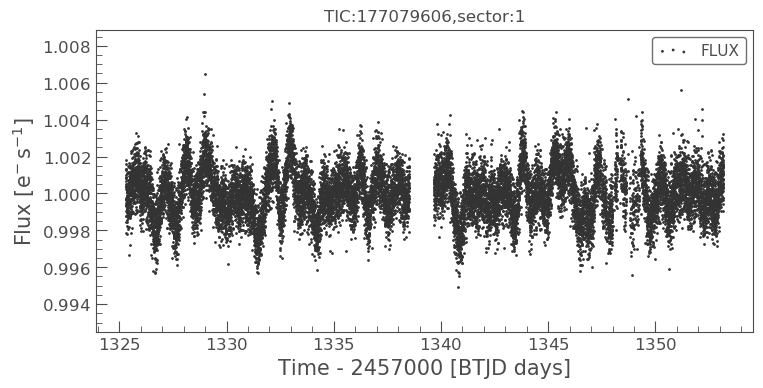

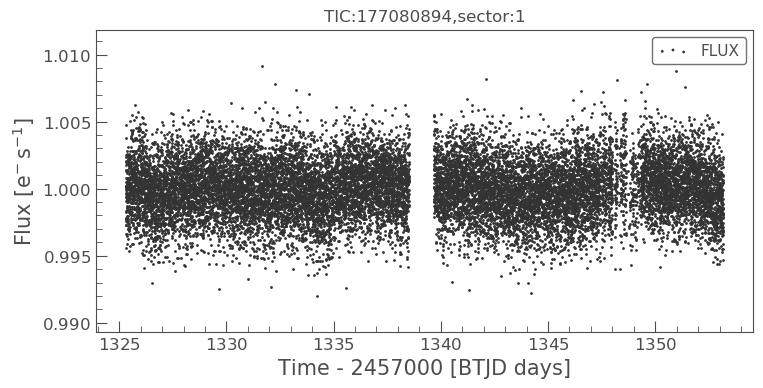

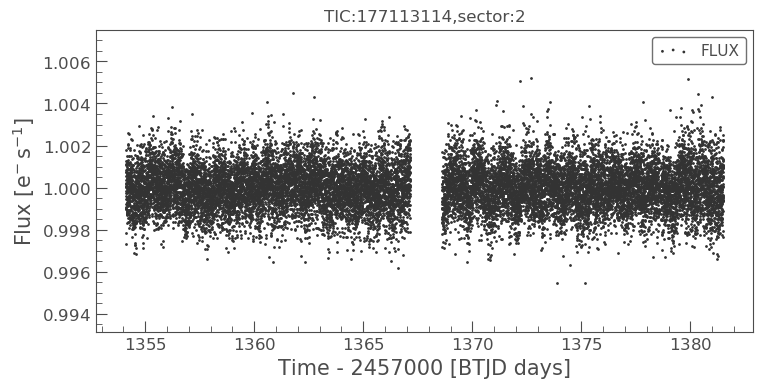

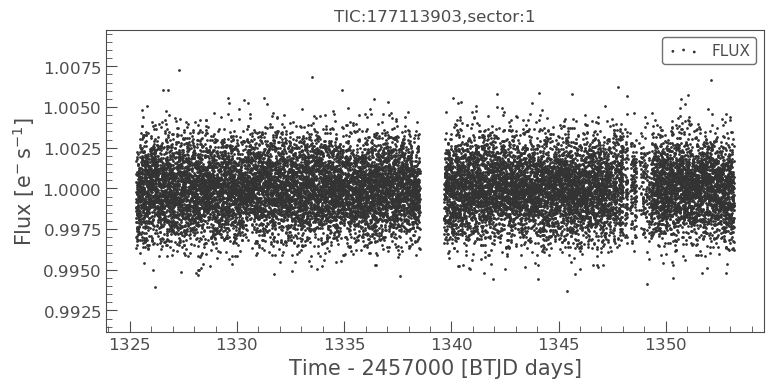

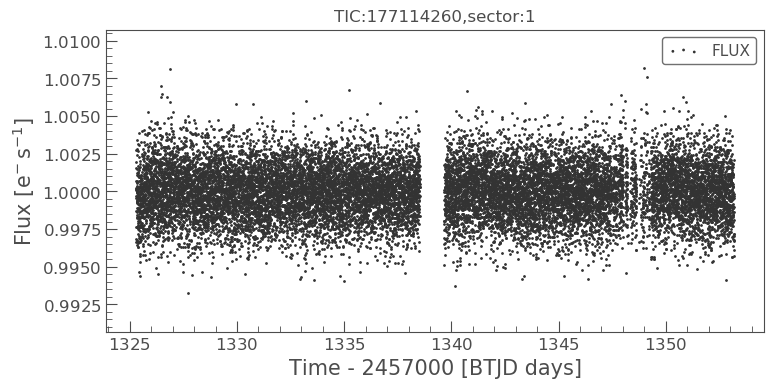

In [72]:
####look at 1st sector for each tic

looping = goodtics[1240:1260] #didnt finish this section
for count,tic in enumerate(looping): #already looked at 1060-1080
    plot_1sector(tic);
    print(count,':',tic)


In [73]:
[print(count,':',tic) for count,tic in enumerate(looping)]; #already looked at 1060-1080
    

0 : 177036977
1 : 177038077
2 : 177038190
3 : 177038886
4 : 177039559
5 : 177039581
6 : 177075293
7 : 177075958
8 : 177077054
9 : 177077137
10 : 177077336
11 : 177077475
12 : 177077527
13 : 177078853
14 : 177078973
15 : 177079606
16 : 177080894
17 : 177113114
18 : 177113903
19 : 177114260


Average LS1 Rotation Period for TIC 177077475 is: 5.5101171136391125
Highest Amplitude from sector: 2
verify: 177077475 matches: 177077475
Stitched RP:  4.359819501667648
Mean of rps less than 6 is:  4.5715815939967435


ID,sector,lsrp1,lsamp1,rvar
int64,int64,float64,float64,float64
177077475,2,8.778680235130523,0.5929813076417383,0.00904138088226325
177077475,3,4.307757918815183,0.3604125302341589,0.007168158888816834
177077475,4,5.783786034793294,0.3238898612566929,0.00678014159202589
177077475,5,9.023356288981287,0.39533584847080255,0.007316172122955322
177077475,6,4.297494449730416,0.3459807015118609,0.0067243874073028564
177077475,7,4.377580609575442,0.43325489674439216,0.005984777212142856
177077475,8,6.236598973944478,0.2779231178032072,0.005740869045257614
177077475,9,4.860837686257012,0.19664906291706835,0.00604894757270813
177077475,10,4.3828991590009,0.3614419854521309,0.006525936722755477


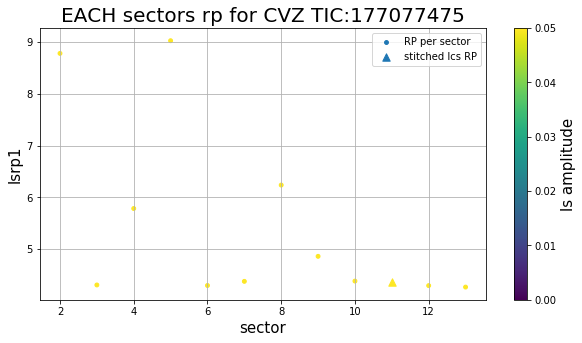

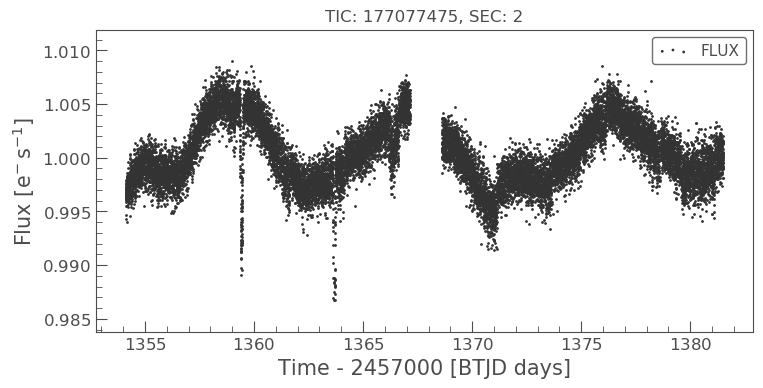

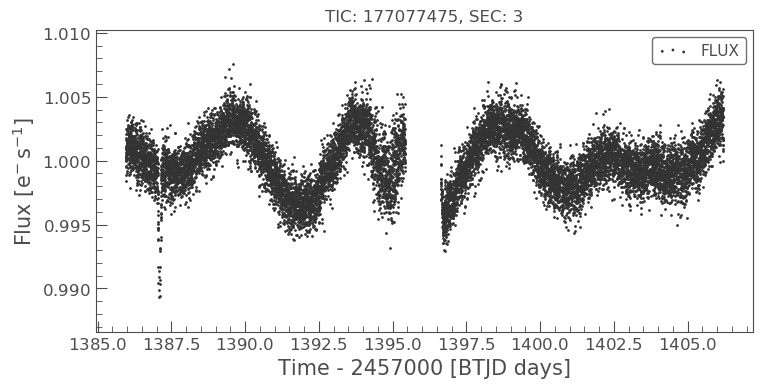

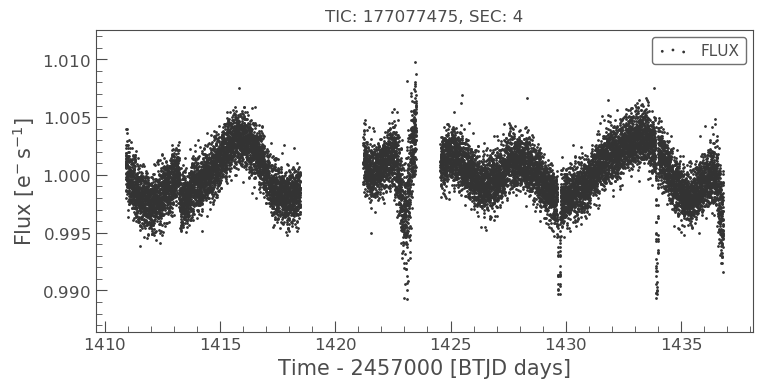

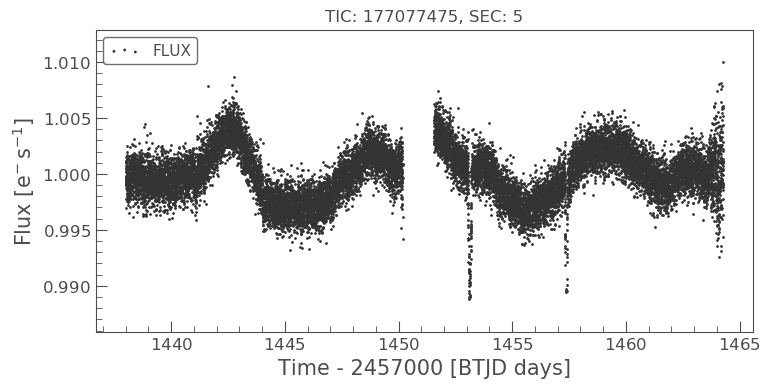

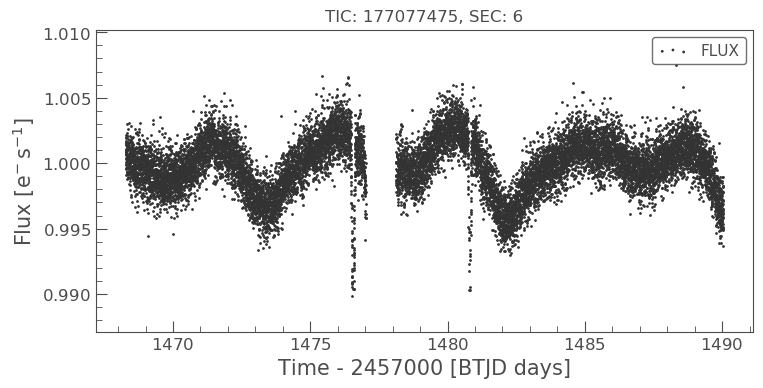

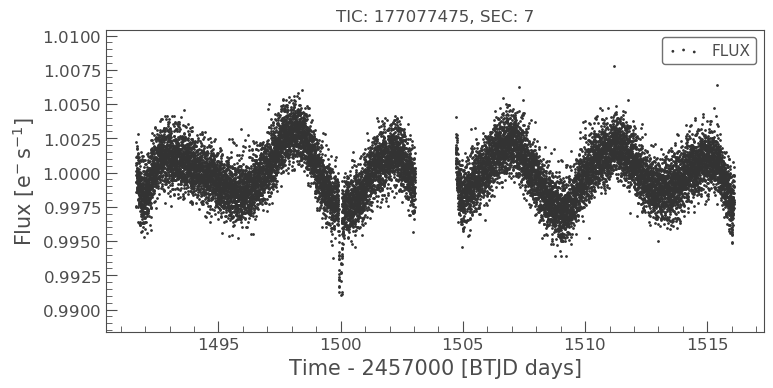

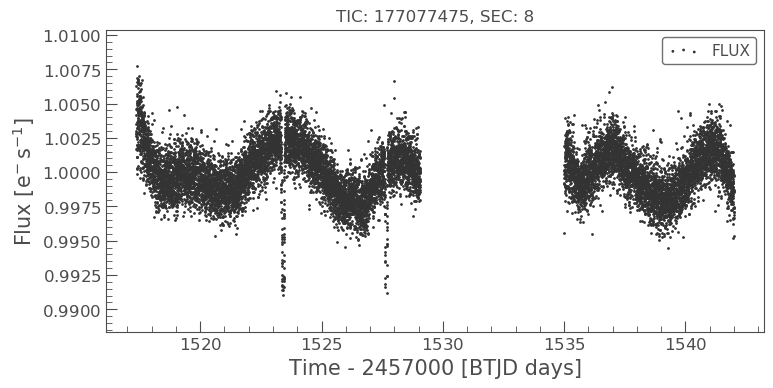

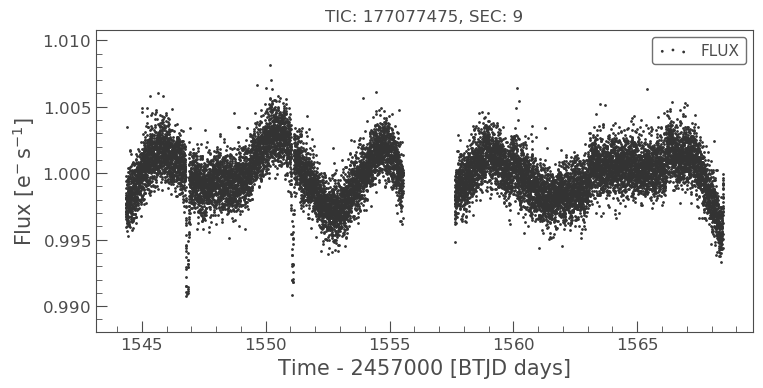

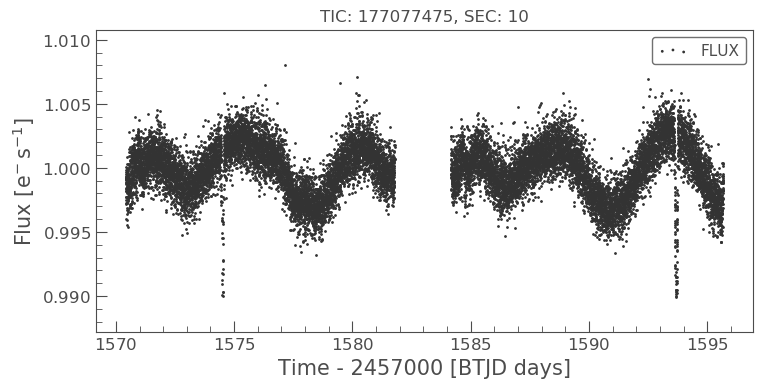

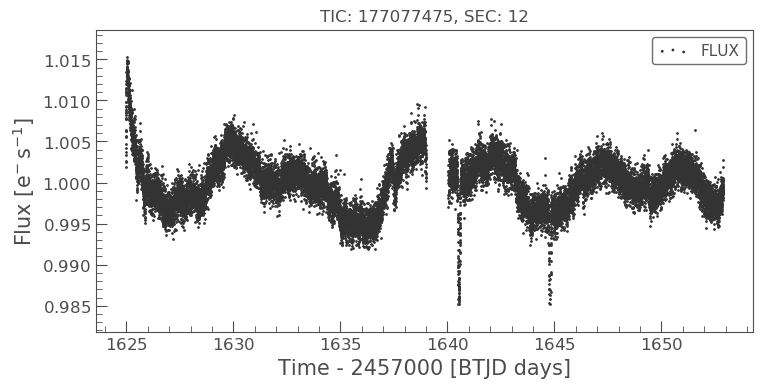

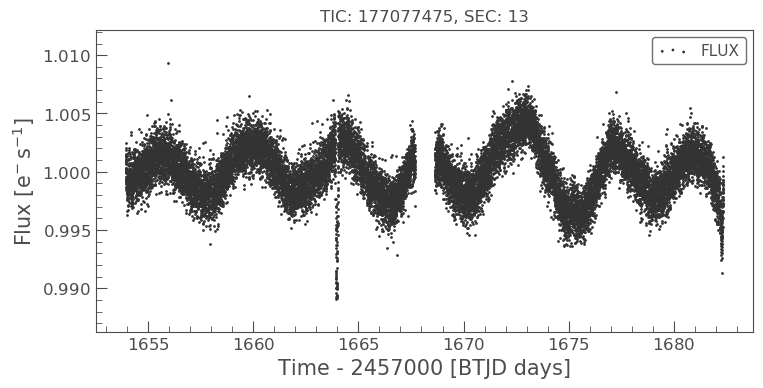

In [9]:
#####explore all sectors for each tic


tic = 177077475
myt = plot_rps(tic,plot=True)
limit = 6
shortmyt = myt[myt['lsrp1']<limit]
avg = np.mean(shortmyt['lsrp1'])
print('Mean of rps less than', limit,'is: ',avg)
myt

# gathering sample stats

In [10]:
bench =[140579537,140581031,140595953,140599471,140609384,140688941,140941153,141271216,\
        141482802,141606958,141624979,141625605,141914082,141977086,141942911,142018697,\
        142142488,142144162,142149242,149120726,149174494,149175396,149217342,149218350,\
        149275235,149273299,149269178,149274312,149308317,149497993,149540013,149902539,\
        149933986,150029671,150028806,149993720,150098542,150104808,150101472,150164124,\
        150188736,150250528,150271420,150299548,150322340,150358147,150359500,150359982,\
        150393064,150393302,150439989,150442658,166975595,167005517,167306154,167340913,\
        167344029,167344197,167364796,167525513,167549377,167550778,167574282,167602025,\
        167695122,167752664,167814315,167888669,167889402,176873028,167895165,176954188,\
        176955610,176980457,176982916,177022213,]

print(len(bench))

76


In [11]:
####pull stats table data for tics in benchmark

#get indices
idxs = []
lens=[]
for i in bench:
    indices = np.where(secstats['ID']==i)
    length = len(indices[0])
    lens.append(length)
    idxs.append(indices[0])
sums = np.sum(lens)
idxs = np.concatenate(idxs)
print('these should match or else investigate!',sums,len(idxs))

#get data using indices
bench_table = secstats[idxs]

these should match or else investigate! 892 892


# exploring sample

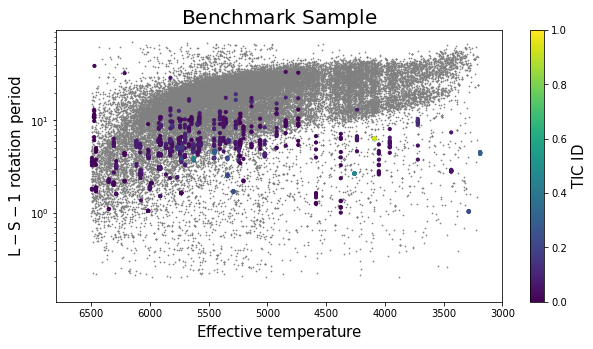

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(bench_table['Teff'],bench_table['ls1'],s=10,c=bench_table['rvar'])#['lsamp1'])
# plt.colorbar().set_label('$\mathrm{Amplitude}$',size=15)
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.5,zorder=0,color = 'grey', rasterized=True)#label='mcquillan is blue');


plt.colorbar().set_label('$\mathrm{TIC~ID}$',size=15)
plt.xlabel('$\mathrm{Effective~temperature}$',size=15)
plt.ylabel('$\mathrm{L-S-1~rotation~period}$',size=15)
plt.title('$\mathrm{Benchmark~Sample}$',size=20);
plt.xlim(6800,3000)
plt.yscale('log');

In [16]:
#og - didnt work right


# #make a table of other tics excluding those in bench
# IDX = []
# for count,i in enumerate(secstats['ID']):
#     for j in bench:
#         if i != j:
#             IDX.append(count)
# print(len(IDX),len(bench))
# therest= secstats[IDX]
# len(therest)

7181268 64


7181268

In [13]:
# remix

#make a table of other tics excluding those in bench
IDX = []
for count,i in enumerate(secstats['ID']):
    if i not in bench:
        IDX.append(count)
print(len(IDX),len(bench))

111327 76


In [14]:
therest= secstats[IDX]
len(therest)

111327

In [15]:
len(secstats) - len(therest) #this proves loop above is incorrect...idx includes indices from benchmarks b/c didnt
#match order of secstats ids

892

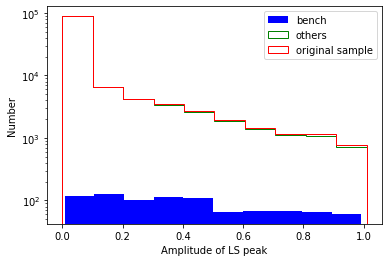

In [18]:
plt.hist(bench_table['lsamp1'],color='b',label='bench')#,histtype='step')
plt.hist(therest['lsamp1'],color='g',histtype='step',label='others')
plt.hist(secstats['lsamp1'],color='r',histtype='step',label='original sample')

plt.legend()
plt.xlabel('Amplitude of LS peak')
#plt.ylim(0,1000)
plt.yscale('log')
plt.ylabel('Number');

In [17]:
# plt.figure(figsize=(10,7))
# plt.scatter(bench_table['Teff'],bench_table['rvar'],color='b',label='benchmark',zorder=1,s=10)#c=bench_table['ID'])#['lsamp1'])
# plt.scatter(therest['Teff'],therest['rvar'],color='g',label='others',zorder=0,s=1,rasterized=True)#c=bench_table['ID'])#['lsamp1'])

# plt.legend()
# plt.xlabel('$\mathrm{Effective~temperature}$',size=15)
# plt.ylabel('$\mathrm{Rvar}$',size=15)
# plt.title('$\mathrm{Benchmark~Sample}$',size=20);